# 前準備

In [1]:
# 用いるライブラリのインポート
import hashlib

import numpy as np
import polars as pl
import polars.selectors as cs
pl.Config(fmt_str_lengths = 50, tbl_cols = 100, tbl_rows = 100)
import statsmodels.formula.api as smf

URL_CH2_LOGDATA = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch2_logdata.csv"
URL_LENTA_DATA = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/lenta_dataset.csv"

# A/Bテストを用いてクリーンに効果検証を行う
## Prelude

#### プログラム2.1 太郎くんの分析の再現

書籍上では次のようなコードになっています。
``` python
import pandas as pd

df = pd.read_csv(URL_CH2_LOGDATA)
df_result = df.groupby("is_treatment")["response_att"].mean() * 100
```

In [2]:
df = pl.read_csv(URL_CH2_LOGDATA)
df_result = df.group_by("is_treatment").agg( pl.mean("response_att") * 100 )

In [3]:
df_result

is_treatment,response_att
i64,f64
0,10.236412
1,5.658671


図表のプロット

<Axes: ylabel='is_treatment'>

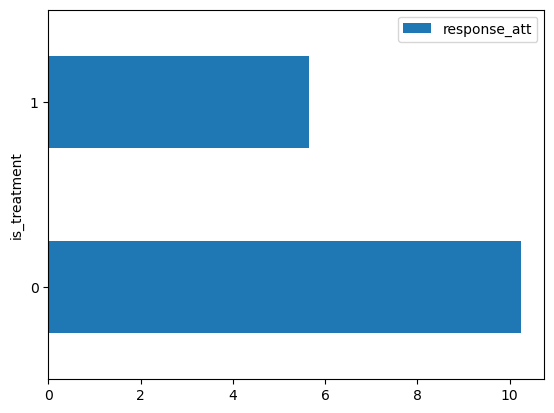

In [5]:
df_result.to_pandas().set_index("is_treatment").plot.barh()

# A/Bテストの基本的な発想

<Axes: ylabel='is_treatment'>

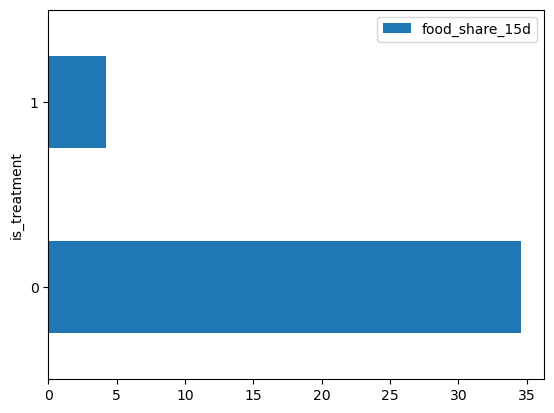

In [7]:
df_result_food_share = (
    pl.read_csv(URL_CH2_LOGDATA)
    .group_by("is_treatment")
    .agg(
        pl.mean("food_share_15d") * 100
    )
)
df_result_food_share.to_pandas().set_index("is_treatment").plot.barh()

In [8]:
(
    pl.read_csv(URL_LENTA_DATA)
    .group_by("is_treatment")
    .agg(
        pl.mean("food_share_15d") * 100
    )
)

is_treatment,food_share_15d
i64,f64
0,34.558005
1,34.88718


# A/Bテストの設計と分析
## A/Bテストの設計
### 割当

#### プログラム2.2 NumPy パッケージのchoice を使ったランダム割当
書籍上では次のようなコードになっています。

``` python
import numpy as np

rng = np.random.default_rng()
is_treatment = rng.choice([0, 1], p=[0.3, 0.7])
```

In [9]:
# 乱数を生成する前にシードを設定することで、コードを修正しても再現性を保つことができる
rng = np.random.default_rng(seed = 0)
is_treatment = rng.choice([0, 1], p = [0.3, 0.7])

In [10]:
is_treatment

1

#### プログラム2.3 ハッシュ化を通じたランダム割当

書籍上では次のようなコードになっています。

``` python
import hashlib

uid = "hogehoge"
hash_value = int(
    hashlib.sha256(f"salt0_{uid}".encode()).hexdigest(), 16
)
if (hash_value % 10) < 3:
    is_treatment = 1
else:
    is_treatment = 0
```

In [11]:
uid = "hogehoge"
hash_value = int(
    hashlib.sha256(f"salt0_{uid}".encode()).hexdigest(), 16
)
if (hash_value % 10) < 3:
    is_treatment = 1
else:
    is_treatment = 0

In [12]:
is_treatment

1

# A/Bテスト

太郎くんのストーリーにある図表の再現

shape: (2, 2)
┌──────────────┬──────────────┐
│ is_treatment ┆ response_att │
│ ---          ┆ ---          │
│ i64          ┆ f64          │
╞══════════════╪══════════════╡
│ 0            ┆ 10.236412    │
│ 1            ┆ 11.145897    │
└──────────────┴──────────────┘


<Axes: ylabel='is_treatment'>

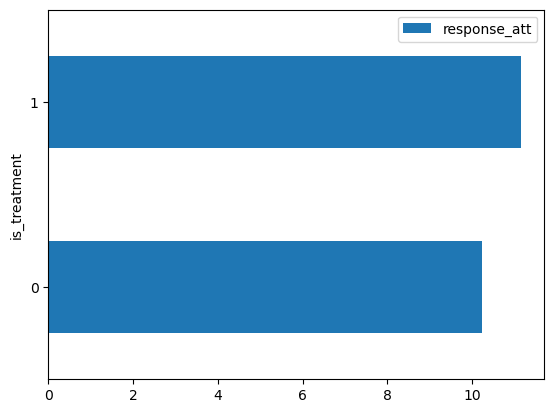

In [13]:
df_result_response = (
    pl.read_csv(URL_LENTA_DATA)
    .group_by("is_treatment")
    .agg(
        pl.mean("response_att") * 100
    )
)
print(df_result_response)
df_result_response.to_pandas().set_index("is_treatment").plot.barh()

# pythonによるプッシュ通知施策効果の検証

#### プログラム2.4 A/B テストによるプッシュ通知施策の効果検証
書籍上では次のようなコードになっています。
``` python
import statsmodels.formula.api as smf

# データの取得
df = pd.read_csv(URL_LENTA_DATA)
# 共変量がバランスしているかを調べる
df_balance_test = df.groupby("is_treatment")[
    ["food_share_15d", "age", "is_women"]
].mean()
# 回帰分析
result = smf.ols(formula="response_att ~ is_treatment", data=df).fit()
result.summary()
```

前準備：データの取得と確認

In [14]:
# データの取得
df = pl.read_csv(URL_LENTA_DATA)
# 共変量がバランスしているかを調べる
df_balance_test = (
    df.group_by("is_treatment")
    .agg([
        pl.mean("food_share_15d"),
        pl.mean("age"),
        pl.mean("is_women"),
    ])
)
# 回帰分析
result = smf.ols(formula = "response_att ~ is_treatment", data = df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           response_att   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.890
Date:                Thu, 13 Jun 2024   Prob (F-statistic):            0.00497
Time:                        06:47:29   Log-Likelihood:                -12692.
No. Observations:               50000   AIC:                         2.539e+04
Df Residuals:                   49998   BIC:                         2.541e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1024      0.003     36.412      0.000       0.097       0.108
is_treatment     0.0091      0.003      2.809      0.005       0.003       0.015
==============================================================================
Omnibus:                    23649.035   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90406.287
Skew:                           2.505   Prob(JB):                         0.00
Kurtosis:                       7.277   Cond. No.                         3.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
df.head(5)

is_treatment,response_att,food_share_15d,age,is_women
i64,i64,f64,f64,i64
1,0,0.0,33.0,1
0,0,0.0,63.0,1
1,0,0.0,51.0,1
0,0,0.0,38.0,1
1,0,0.5105,20.0,1


In [16]:
df_balance_test

is_treatment,food_share_15d,age,is_women
i64,f64,f64,f64
0,0.34558,43.578986,0.618734
1,0.348872,43.803353,0.629673


## （未収録） 共変量を加えても結果が大きく変わらないことを確認する

In [17]:
# 回帰分析
result = smf.ols(
    "response_att ~ is_treatment + food_share_15d + age + is_women",
    data=df,
).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           response_att   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     655.4
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:48:33   Log-Likelihood:                -11048.
No. Observations:               49152   AIC:                         2.211e+04
Df Residuals:                   49147   BIC:                         2.215e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0539      0.005     10.555      0.000       0.044       0.064
is_treatment       0.0072      0.003      2.285      0.022       0.001       0.013
food_share_15d     0.1713      0.003     51.131      0.000       0.165       0.178
age               -0.0003    9.3e-05     -3.047      0.002      -0.000      -0.000
is_women           0.0033      0.003      1.157      0.247      -0.002       0.009
==============================================================================
Omnibus:                    21428.610   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75038.647
Skew:                           2.317   Prob(JB):                         0.00
Kurtosis:                       6.895   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 13 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

polars     : 0.20.31
statsmodels: 0.14.1
numpy      : 1.26.4

Watermark: 2.4.3

